In [1]:
# python v3.10.11
# import necessary packages

import os
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np

import sys
sys.path.append('functions')
from gene_analysis_functions import get_cistrome


from matplotlib_venn import venn3
from matplotlib_venn.layout.venn3 import DefaultLayoutAlgorithm

from scipy.stats import hypergeom

%matplotlib inline
%load_ext autoreload
%autoreload 2

Set the directory and get the relevant information

In [2]:
#os.chdir('C:\\Users\\Q004\\Desktop\\pellegrini_lab_research\\model_outputs\\')
os.chdir('C:\\Users\\Sam Anderson\\Desktop\\pellegrini_lab_research\\model_outputs\\')

death_pvals = pd.read_excel('death_classifier_probes.xlsx', index_col=0)
pinv_pvals = pd.read_excel('pseudoinverse_probes_filtered.xlsx', index_col=0)

#os.chdir('C:\\Users\\Q004\\Desktop\\pellegrini_lab_research\\raw_data\\')
os.chdir('C:\\Users\\Sam Anderson\\Desktop\\pellegrini_lab_research\\raw_data\\')

all_probes = pd.read_excel('methylation_phenotype_encoded.xlsx', index_col=0)
all_probes = all_probes[55:]

Get the probes associated with strain

In [3]:
# get the p values
strain_probes = pinv_pvals.copy()

# make the insignificant values = nan
strain_probes['C57BL6J or Sv129Ev?_pval'] = strain_probes['C57BL6J or Sv129Ev?_pval'].apply(lambda x: np.nan if x > 0.01 else x)
strain_probes['CD1 or C57BL6J?_pval'] = strain_probes['CD1 or C57BL6J?_pval'].apply(lambda x: np.nan if x > 0.01 else x)

# average the p values
strain_probes['strain_pval'] = strain_probes.apply(lambda row: np.nanmean([row['C57BL6J or Sv129Ev?_pval'], row['CD1 or C57BL6J?_pval']]) 
                        if pd.notna(row['C57BL6J or Sv129Ev?_pval']) or pd.notna(row['CD1 or C57BL6J?_pval']) 
                        else np.nan, axis=1)

# select the column of interest
strain_probes = strain_probes['strain_pval']

# drop the insignificant p values
strain_probes = strain_probes.dropna()

# get a list of significant probes
strain_probes = list(strain_probes.index)
print(f'Number of strain probes: {len(strain_probes)}')

Number of strain probes: 11026


Get the probes associated with strain


In [6]:
# get the p values
glucose_probes = pinv_pvals.copy()

# make the insignificant values = nan
glucose_probes['M14_aging_phase_GLU_pval'] = glucose_probes['M14_aging_phase_GLU_pval'].apply(lambda x: np.nan if x > 0.01 else x)
glucose_probes['M16_aging_phase_GLU_pval'] = glucose_probes['M16_aging_phase_GLU_pval'].apply(lambda x: np.nan if x > 0.01 else x)

# average the p values
glucose_probes['blood_glucose_pval'] = glucose_probes.apply(lambda row: np.nanmean([row['M14_aging_phase_GLU_pval'], row['M16_aging_phase_GLU_pval']]) 
                        if pd.notna(row['M14_aging_phase_GLU_pval']) or pd.notna(row['M16_aging_phase_GLU_pval']) 
                        else np.nan, axis=1)

# select the column of interest
glucose_probes = glucose_probes['blood_glucose_pval']

# drop the insignificant p values
glucose_probes = glucose_probes.dropna()

# get a list of significant probes
glucose_probes = list(glucose_probes.index)
print(f'Number of blood glucose probes: {len(glucose_probes)}')

Number of blood glucose probes: 89


Get the probes associated with age

In [7]:
age_probes = death_pvals
age_probes = age_probes.dropna()
age_probes = list(age_probes.index)
print(f'Number of aging probes: {len(age_probes)}')

Number of aging probes: 9243


Print out the number of intersections between the probe sets

In [8]:
glu_age = list(set(glucose_probes) & set(age_probes))
glu_strain = list(set(glucose_probes) & set(strain_probes))
strain_age = list(set(strain_probes) & set(age_probes))
glu_strain_age = list(set(glucose_probes) & set(strain_probes) & set(age_probes))

print(f'intersection between blood glucose and aging sets: {len(glu_age)}')
print(f'intersection between blood glucose and strain sets: {len(glu_strain)}')
print(f'intersection between strain and aging sets: {len(strain_age)}')
print(f'intersection between blood glucose, strain, and aging sets: {len(glu_strain_age)}')

intersection between blood glucose and aging sets: 32
intersection between blood glucose and strain sets: 89
intersection between strain and aging sets: 939
intersection between blood glucose, strain, and aging sets: 32


Define functions for plot generation (specifically a scatterplot)

In [9]:
# extract genes from associated_genes column
def extract_genes(gene_string):
    genes = []
    n_genes = gene_string.count(', ')
    n = 0
    while n < n_genes + 1:
        index_space = gene_string.find(' ')
        gene_n = gene_string[:index_space]
        genes.append(gene_n)
        index_comma = gene_string.find(', ')
        gene_string = gene_string[index_comma + 2:]
        n += 1
    return genes

# apply the function to each entry in 'associated_genes' column
def apply_gene_extraction(cross_identified_probes):
    associated_genes_full = [gene for gene in cross_identified_probes['associated_genes']]
    cross_identified_probes['genes'] = cross_identified_probes['associated_genes'].apply(extract_genes)

    # Count occurrences of each gene across all entries
    gene_counts = pd.Series([gene for genes_list in cross_identified_probes['genes'] for gene in genes_list]).value_counts()
    return associated_genes_full, gene_counts

def define_marker_style(cross_identified_probes, gene_counts):
    duplicates = gene_counts[gene_counts > 1].index.tolist()
    marker_style = []
    
    # Swapping markers logic: 'x' for duplicated genes, 'o' for non-duplicated genes
    for genes in cross_identified_probes['associated_genes']:
        to_append = 'o'  # default to 'o' (circle) for non-duplicated genes
        for gene in duplicates:
            if gene in genes:
                to_append = 'x'  # swap to 'x' for duplicated genes
        marker_style.append(to_append)

    return marker_style

# Function to plot scatter plot with dynamic data
def plot_scatter(ax, cross_identified_probes):
    associated_genes_full, gene_counts = apply_gene_extraction(cross_identified_probes)
    marker_style = define_marker_style(cross_identified_probes, gene_counts)

    sns.scatterplot(data=cross_identified_probes, x='coef', y='ID', style=marker_style, markers=['X', 'o'], s=200, 
                    legend=False, palette='viridis_d', hue='coef', ax=ax)

    # Add legend showing repeated genes
    props = dict(boxstyle='round', facecolor='green', alpha=0.5)
    gene_counts = gene_counts.to_dict()
    repeated = {key: value for key, value in gene_counts.items() if value > 1}
    gene_list_formatted = '\n'.join(f"{key} ({value}x)" for key, value in repeated.items())
    ax.text(0.03, 0.96, f'Duplicated Genes:\n\n{gene_list_formatted}', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Annotate each point with associated genes
    for i, genes in enumerate(associated_genes_full):
        x = cross_identified_probes['coef'][i]
        y = cross_identified_probes.index[i]
        ax.annotate(genes, (x, y), textcoords="offset points", xytext=(10, -3), ha='left', size=9)

    ax.set_xlabel('elastic net coefficient', size=18)
    ax.set_ylabel('probes', size=18)
    ax.set_facecolor((1, 1, 0.8509803921))  # Same as plot included in same figure
    ax.set_xlim(-0.15, 0.3)

Generate plots showing set intersection

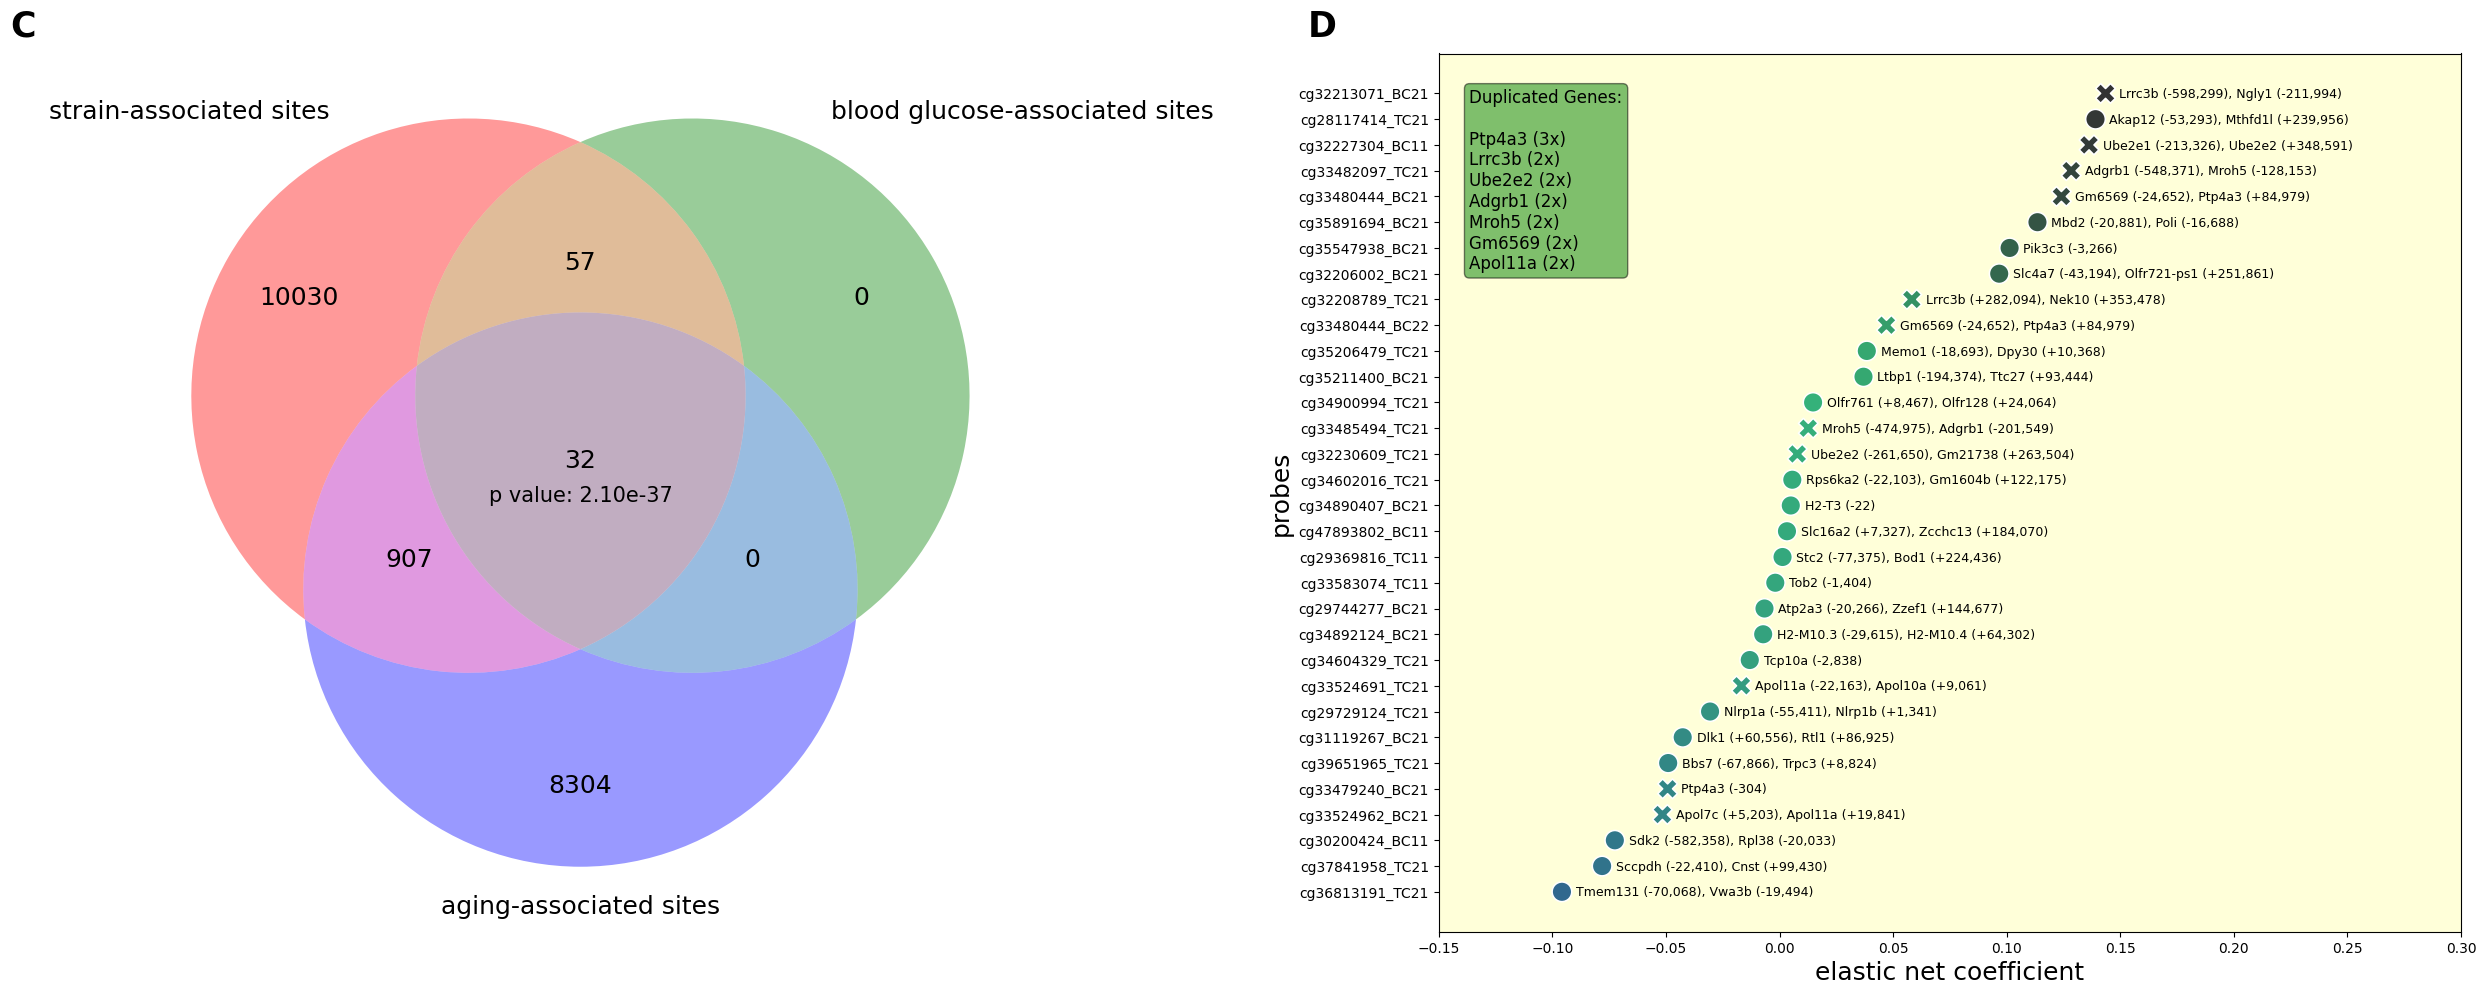

In [10]:
# get a dataframe of the intersection between the aging associated probes and the blood glucose associated probes
cross = death_pvals.loc[glu_age]
cross = cross[['coef', 'associated_genes']]
cross = cross.rename_axis('ID').reset_index()
glu_age_df = cross.sort_values(by='coef', ascending=False, ignore_index=True) # sort these so the legend is not obscured

# get a dataframe of the intersection between all three sets
cross = death_pvals.loc[glu_strain_age]
cross = cross[['coef', 'associated_genes']]
cross = cross.rename_axis('ID').reset_index()
glu_strain_age_df = cross.sort_values(by='coef', ascending=False, ignore_index=True) # sort these so the legend is not obscured

# create 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 10))  # Adjust the figure size as needed

# get each set of probes
set1 = set(strain_probes)      
set2 = set(glucose_probes) 
set3 = set(age_probes)  

# create a venn diagram using these sets of probes
venn = venn3([set1, set2, set3], ('strain-associated sites', 'blood glucose-associated sites', 'aging-associated sites'), ax=axs[0], layout_algorithm=DefaultLayoutAlgorithm(fixed_subset_sizes=(1,1,1,1,1,1,1)))

# adjust params
for text in venn.set_labels:
    text.set_fontsize(18)

for text in venn.subset_labels:
    text.set_fontsize(18) 

# get the p value for the intersection of sets

# Parameters
N = all_probes.shape[0]  # Total number of elements in the universal set
n_A = len(glucose_probes)  # Size of set A
n_B = len(strain_probes)  # Size of set B
n_C = len(age_probes)  # Size of set C
K = len(glu_strain_age)    # Total number of elements in the intersection (estimated or known)
k = len(glu_strain_age)     # Observed size of intersection |A ∩ B ∩ C|

# Calculate the total size of the union of the three sets
n_total = n_A + n_B + n_C

# Calculate the p-value for the intersection
p_value = hypergeom.sf(k - 1, N, K, n_total)
axs[0].text(0.5, 0.49, f'p value: {"{:.2e}".format(p_value)}', size=15, ha='center', transform=axs[0].transAxes)
######

# add subplot indicators C and D for combination with other plot
axs[0].text(-0.1, 1.05, 'C', transform=axs[0].transAxes, 
            fontsize=25, fontweight='bold', va='top', ha='right')
axs[1].text(-0.1, 1.05, 'D', transform=axs[1].transAxes, 
            fontsize=25, fontweight='bold', va='top', ha='right')

# create a scatterplot showing the intersection between all three sets aging, blood glucose, and strain probes
plot_scatter(axs[1], glu_age_df)
plt.tight_layout()

Get cistrome plot for intersection

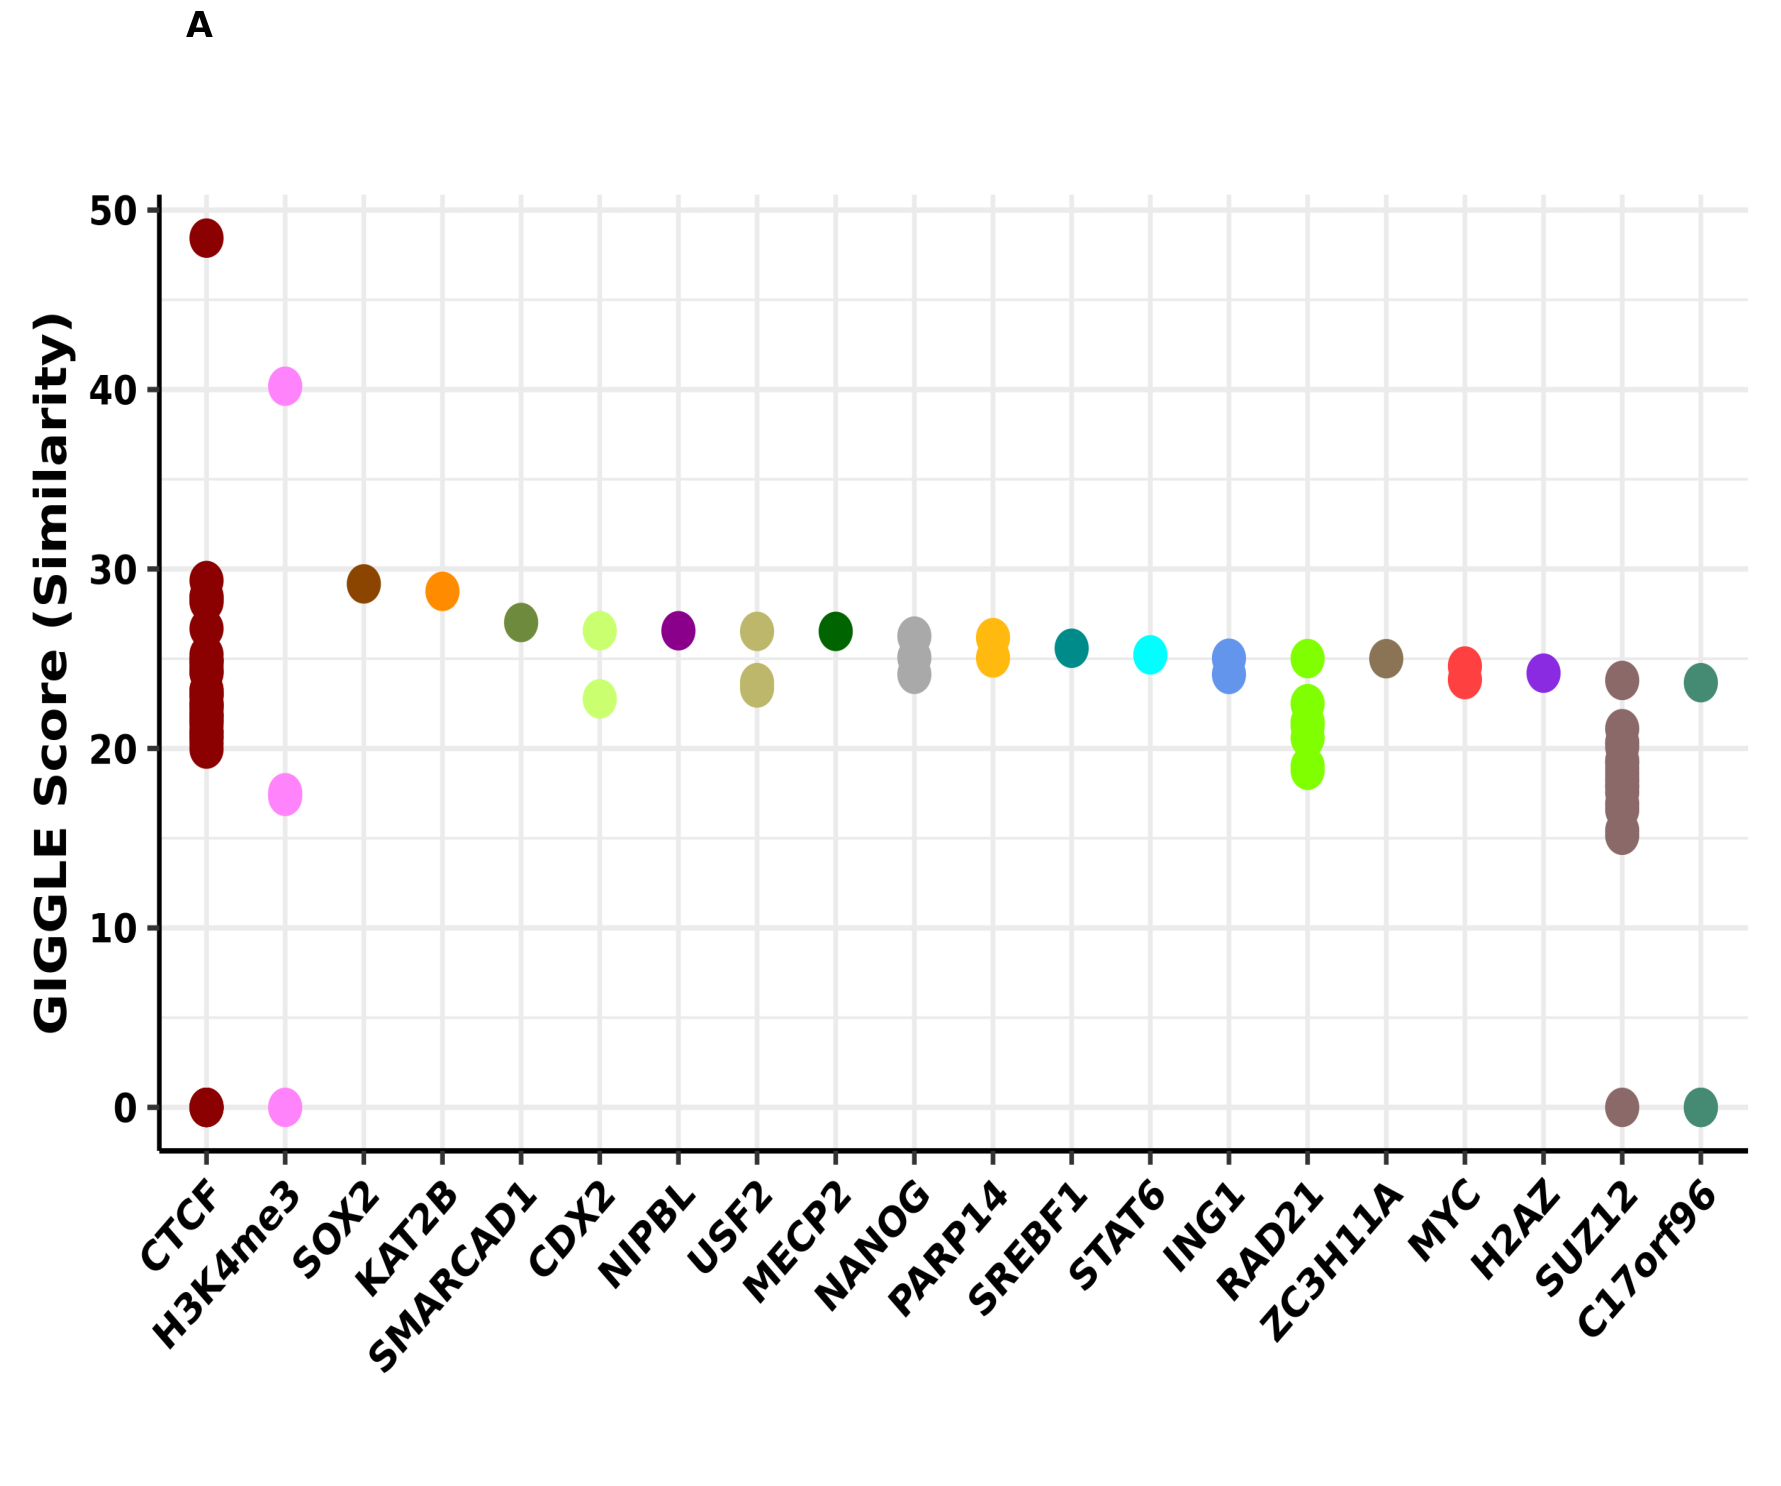

In [26]:
%matplotlib inline

# this is trial and error, unfortunately
'''
2000 for 2
3500 for 3/4
5000 for 5/6
'''
fig_w = 2800
fig_h = 2000

# generate cistrome plots by trait
trait_factors = get_cistrome(pinv_pvals.loc[glu_strain_age][['chr_mm10', 'pos_mm10', 'end_mm10']], fig_w=5000, fig_h=1700, check_coef=False)

In [27]:
trait_factors

{'chr_mm10': {'Mull_M_Y-Cr143.01;Muller Cell': ['CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF'],
  'Brain': ['H3K4me3',
   'H3K4me3',
   'H3K4me3',
   'H3K4me3',
   'H3K4me3',
   'H3K4me3',
   'H3K4me3',
   'H3K4me3',
   'H3K4me3'],
  'EL-4': ['CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF'],
  'Embryonic Stem Cell': ['SOX2',
   'SMARCAD1',
   'CTCF',
   'SOX2',
   'SMARCAD1',
   'CTCF',
   'SOX2',
   'SMARCAD1',
   'CTCF',
   'SOX2',
   'SMARCAD1',
   'CTCF',
   'SOX2',
   'SMARCAD1',
   'CTCF',
   'SOX2',
   'SMARCAD1',
   'CTCF',
   'SOX2',
   'SMARCAD1',
   'CTCF',
   'SOX2',
   'SMARCAD1',
   'CTCF',
   'SOX2',
   'SMARCAD1',
   'CTCF'],
  'Islet': ['KAT2B',
   'KAT2B',
   'KAT2B',
   'KAT2B',
   'KAT2B',
   'KAT2B',
   'KAT2B',
   'KAT2B',
   'KAT2B'],
  'Mammary Gland': ['CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF',
   'CTCF'],
  'Embryonic Fibrob